# **Problem Statement**
An education company named X Education sells online courses to industry professionals. On any given day, many professionals who are interested in the courses land on their website and browse for courses.

The company markets its courses on several websites and search engines like Google. Once these people land on the website, they might browse the courses or fill up a form for the course or watch some videos. When these people fill up a form providing their email address or phone number, they are classified to be a lead. Moreover, the company also gets leads through past referrals. Once these leads are acquired, employees from the sales team start making calls, writing emails, etc. Through this process, some of the leads get converted while most do not.

In this classification notebook we are trying to predict whether the lead will be converted or not



In [1]:
import warnings
warnings.filterwarnings('ignore')

# Importing Pandas and NumPy
import pandas as pd, numpy as np

# Importing sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

# Importing matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Importing statsmodel
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
import pandas as pd

data = "https://raw.githubusercontent.com/sakhareni/INFO-6105-Assignment-2-AutoML/main/leads.csv"

# Read the CSV file from the URL into a Pandas DataFrame
data = pd.read_csv(data)

# Display information about the DataFrame
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [3]:
data.isnull().sum()

Prospect ID                                         0
Lead Number                                         0
Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       137
Total Time Spent on Website                         0
Page Views Per Visit                              137
Last Activity                                     103
Country                                          2461
Specialization                                   1438
How did you hear about X Education               2207
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Search                                              0
Magazine                                            0
Newspaper Article           

# Dropping text with more than **70% Null values** and carrying out data cleaning

In [4]:
data.shape

round(100 * (data.isnull().sum()/len(data.index)), 2)

missing_percentage = round(100 * (data.isnull().sum() / len(data.index)), 2)

columns_to_drop = missing_percentage[missing_percentage > 70].index

data = data.drop(columns=columns_to_drop)

round(100 * (data.isnull().sum()/len(data.index)), 2)

# We have 51% NULL values here so we need to replace the NULL values.
# "Not Sure" seems to be the most neutral value
data['Lead Quality'] = data['Lead Quality'].replace(np.nan,"Not Sure")

data.isnull().sum()

Prospect ID                                         0
Lead Number                                         0
Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       137
Total Time Spent on Website                         0
Page Views Per Visit                              137
Last Activity                                     103
Country                                          2461
Specialization                                   1438
How did you hear about X Education               2207
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Search                                              0
Magazine                                            0
Newspaper Article           

# Carrying out data replacement and column removal of unrelated data




In [5]:
data["City"] = data["City"].replace(np.NaN,"Mumbai")

data["Tags"] = data["Tags"].replace(np.NaN, "Will revert after reading the email")

data["Specialization"] = data["Specialization"].replace(np.NaN,"Others")

data["What matters most to you in choosing a course"] = data["What matters most to you in choosing a course"].replace(np.NaN,"Better Career Prospects")

data = data.drop(['Asymmetrique Activity Index'], axis=1, errors='ignore')

data = data.drop(['Asymmetrique Profile Index'], axis=1, errors='ignore')

data = data.drop(['Asymmetrique Activity Score'], axis=1, errors='ignore')

data = data.drop(['Asymmetrique Profile Score'], axis=1, errors='ignore')

data = data.drop(['Lead Number'], axis=1, errors='ignore')

data = data.drop(['Prospect ID'], axis=1, errors='ignore')

data["What is your current occupation"] = data["What is your current occupation"].replace(np.NaN,"Unemployed")

data["Country"] = data["Country"].replace(np.NaN,"India")

data["TotalVisits"] = data["TotalVisits"].replace(np.NaN,data["TotalVisits"].mean())

data["Page Views Per Visit"] = data["Page Views Per Visit"].replace(np.NaN,data["Page Views Per Visit"].mean())

data["Last Activity"] = data["Last Activity"].replace(np.NaN,"Email Opened")

data["Lead Source"] = data["Lead Source"].replace(np.NaN,"Google")

data["Country"] = data["Country"].replace(np.NaN,"India")

data["Tags"] = data["Tags"].replace(np.NaN,"Will revert after reading the email")

round(100 * (data.isnull().sum()/len(data.index)), 2)

data = data.drop(['How did you hear about X Education'], axis=1, errors='ignore')

data = data.drop(['Lead Profile'], axis=1, errors='ignore')

round(100 * (data.isnull().sum()/len(data.index)), 2)

Lead Origin                                      0.0
Lead Source                                      0.0
Do Not Email                                     0.0
Do Not Call                                      0.0
Converted                                        0.0
TotalVisits                                      0.0
Total Time Spent on Website                      0.0
Page Views Per Visit                             0.0
Last Activity                                    0.0
Country                                          0.0
Specialization                                   0.0
What is your current occupation                  0.0
What matters most to you in choosing a course    0.0
Search                                           0.0
Magazine                                         0.0
Newspaper Article                                0.0
X Education Forums                               0.0
Newspaper                                        0.0
Digital Advertisement                         

# Label Encoding the values since my columns values has values like high,medium,low

---



In [6]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'data' is your DataFrame
label_encoder = LabelEncoder()

# List of non-integer columns (object data type)
object_columns = data.select_dtypes(include=['object']).columns

# Apply label encoding to each non-integer column
for column in object_columns:
    data[column] = label_encoder.fit_transform(data[column])

# Display the updated DataFrame
print(data.head())

   Lead Origin  Lead Source  Do Not Email  Do Not Call  Converted  \
0            0            6             0            0          0   
1            0            7             0            0          0   
2            1            1             0            0          1   
3            1            1             0            0          0   
4            1            3             0            0          1   

   TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0.0                            0                   0.0   
1          5.0                          674                   2.5   
2          2.0                         1532                   2.0   
3          1.0                          305                   1.0   
4          2.0                         1428                   1.0   

   Last Activity  Country  ...  Through Recommendations  \
0             10       12  ...                        0   
1              5       12  ...                      

# Carrying out outlier removal

Number of columns before selection: 29
Number of numeric columns: 29


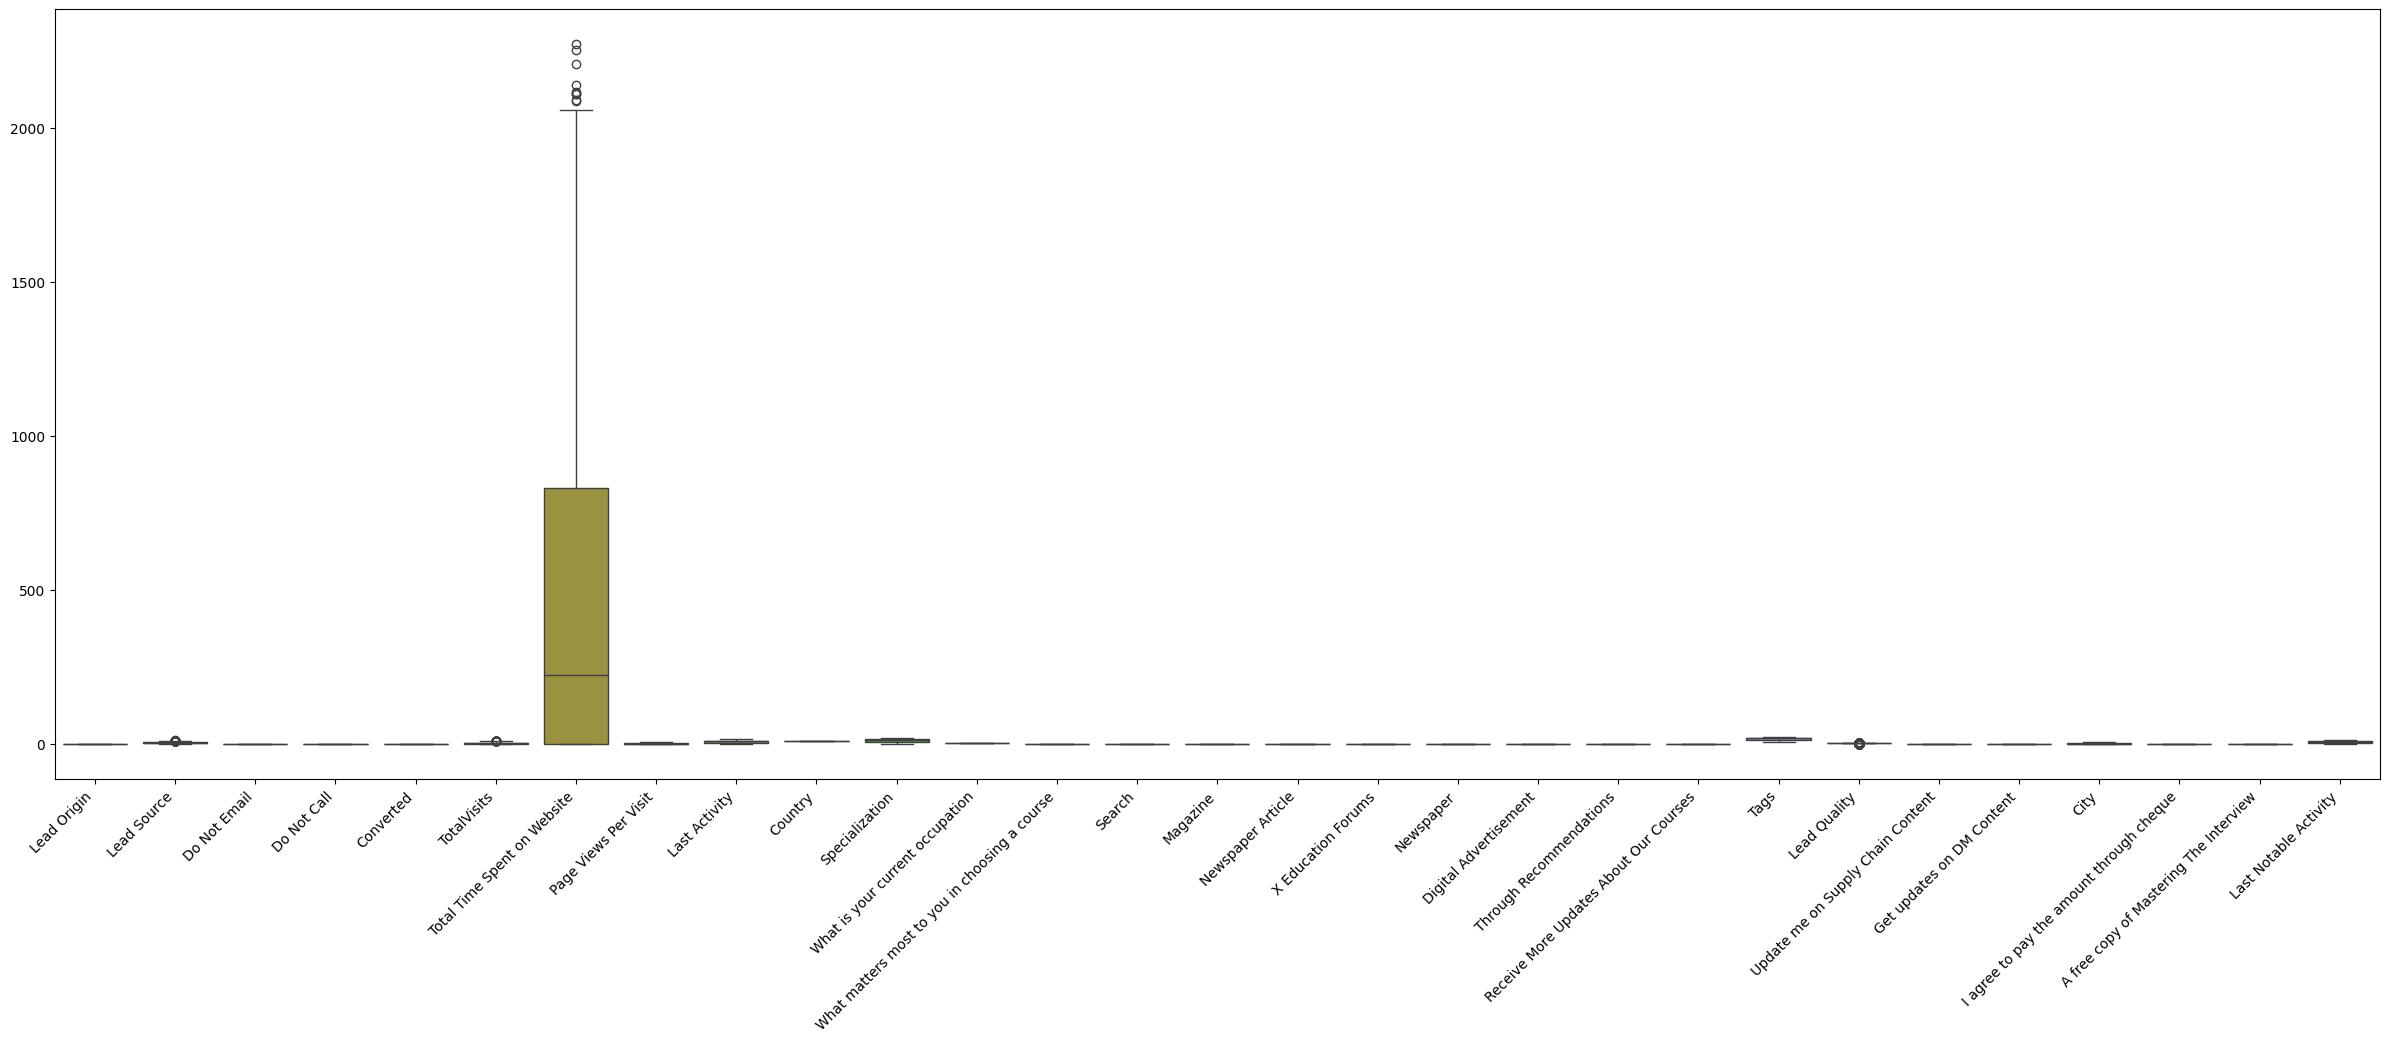

Number of columns after boxplot code: 29


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' is your original DataFrame

print("Number of columns before selection:", data.shape[1])

# Select only numeric columns
numeric_data = data.select_dtypes(include=['number'])
print("Number of numeric columns:", numeric_data.shape[1])

# Define a function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from each numeric column
for column in numeric_data.columns:
    numeric_data = remove_outliers(numeric_data, column)

# Plot the boxplot after removing outliers
plt.figure(figsize=(30, 10))
sns.boxplot(data=numeric_data)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

# Check the number of columns after the boxplot code
print("Number of columns after boxplot code:", numeric_data.shape[1])

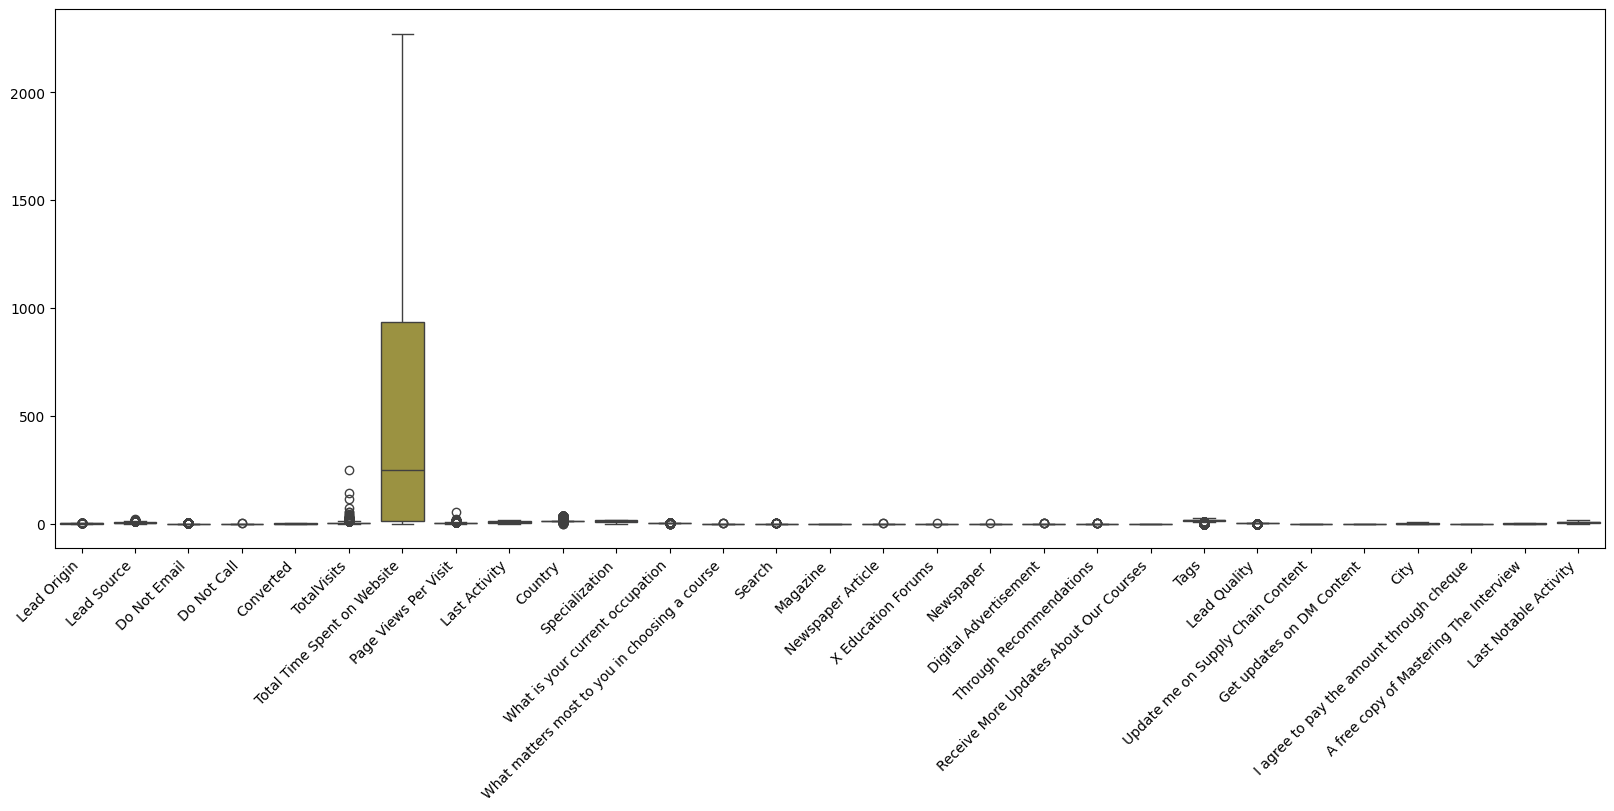

In [8]:
plt.figure(figsize=(20, 7))
sns.boxplot(data=data)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels by 45 degrees
plt.show()

# Normalizing values **Total Time Spent on Website** since the scale of it should match other values


In [9]:
from sklearn.preprocessing import MinMaxScaler

# Assuming 'Lead Number' is a column in your DataFrame called 'data'
# Replace 'data' and 'Lead Number' with your actual DataFrame and column names

# Extract the column for normalization
lead_number_column = data['Total Time Spent on Website']

# Reshape the data as MinMaxScaler expects a 2D array
lead_number_column_reshaped = lead_number_column.values.reshape(-1, 1)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data using Min-Max scaling
lead_number_normalized = scaler.fit_transform(lead_number_column_reshaped)

# Replace the original column with the normalized values
data['Total Time Spent on Website'] = lead_number_normalized.flatten()

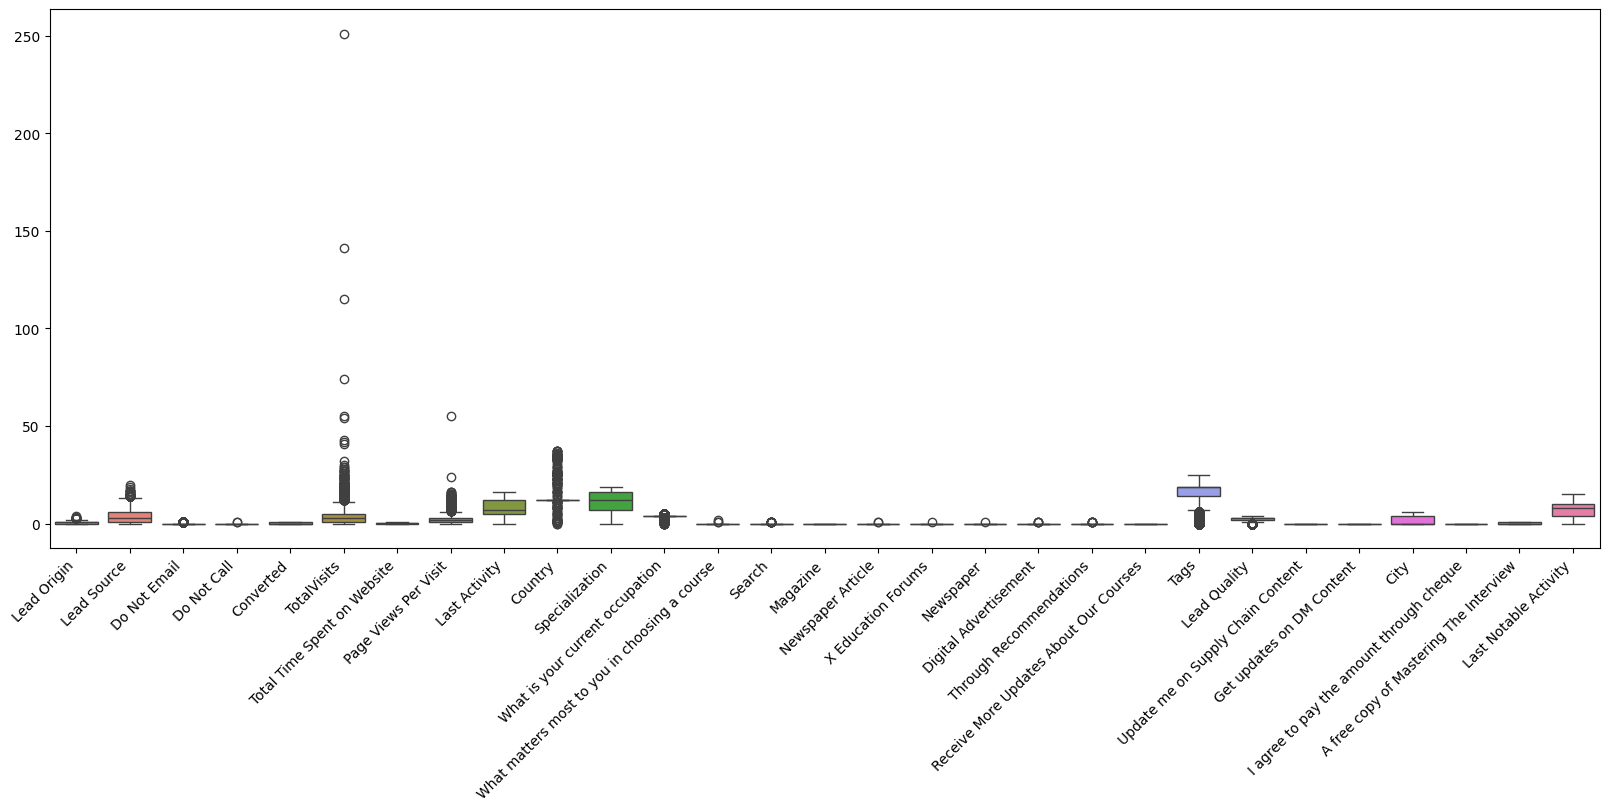

In [10]:
plt.figure(figsize=(20, 7))
sns.boxplot(data=data)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels by 45 degrees
plt.show()

# **The columns have been dropped since they have not contributed to the predictions and have dropped them on basis of operations from previous assignments**

In [11]:
columns_to_drop = ['Country','Search','Magazine','Newspaper Article','X Education Forums','Newspaper',
                   'Digital Advertisement','Through Recommendations','Receive More Updates About Our Courses',
                   'Update me on Supply Chain Content','Get updates on DM Content','I agree to pay the amount through cheque',
                  'A free copy of Mastering The Interview','What matters most to you in choosing a course']

In [12]:
data = data.drop(columns_to_drop,axis = 1)

In [13]:
data.shape
data.nunique()

Lead Origin                           5
Lead Source                          21
Do Not Email                          2
Do Not Call                           2
Converted                             2
TotalVisits                          42
Total Time Spent on Website        1731
Page Views Per Visit                115
Last Activity                        17
Specialization                       20
What is your current occupation       6
Tags                                 26
Lead Quality                          5
City                                  7
Last Notable Activity                16
dtype: int64

In [14]:
data.isnull().values.any()


False

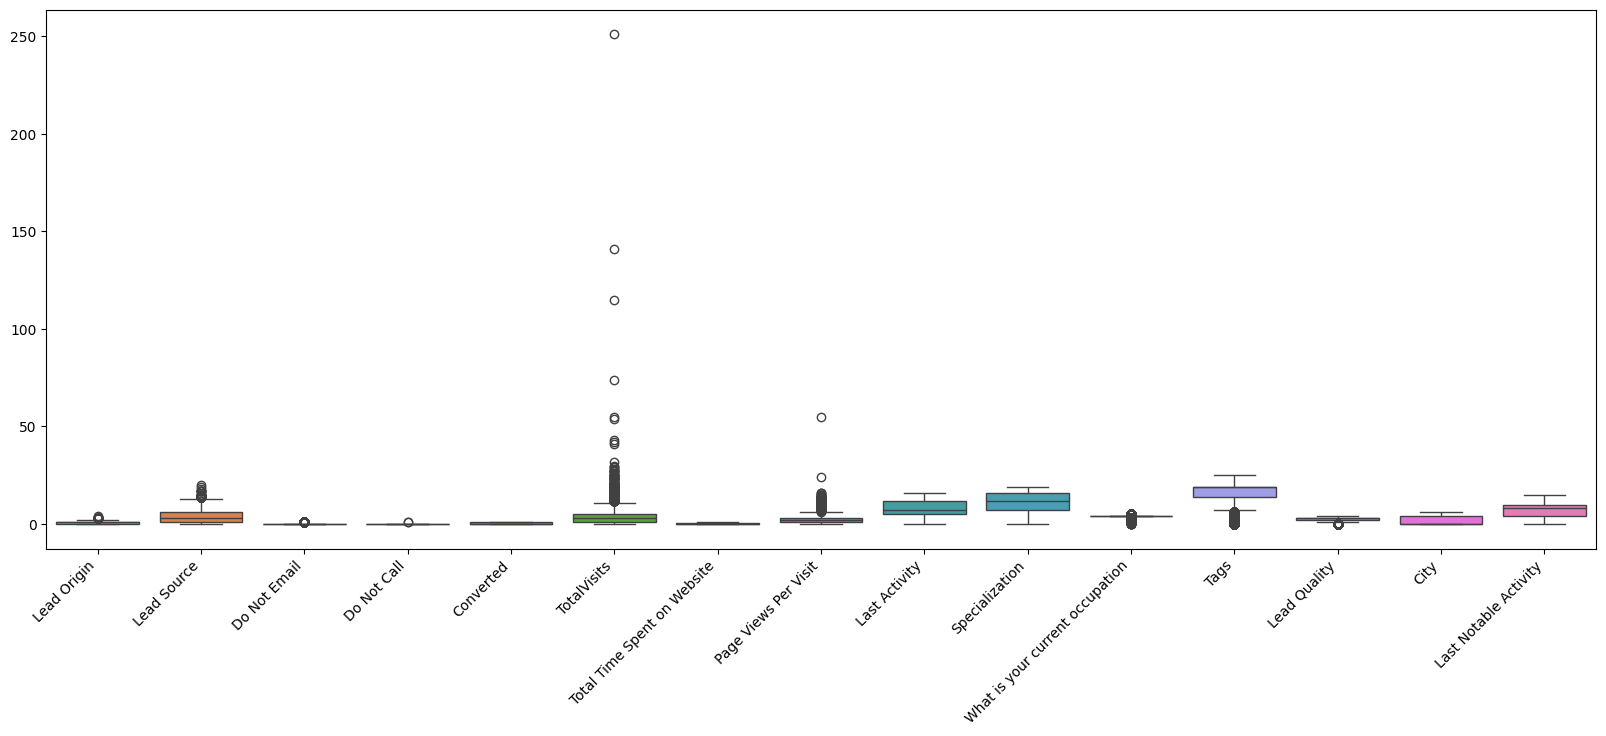

In [15]:
plt.figure(figsize=(20, 7))
sns.boxplot(data=data)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels by 45 degrees
plt.show()

Number of columns before selection: 15
Number of numeric columns: 15


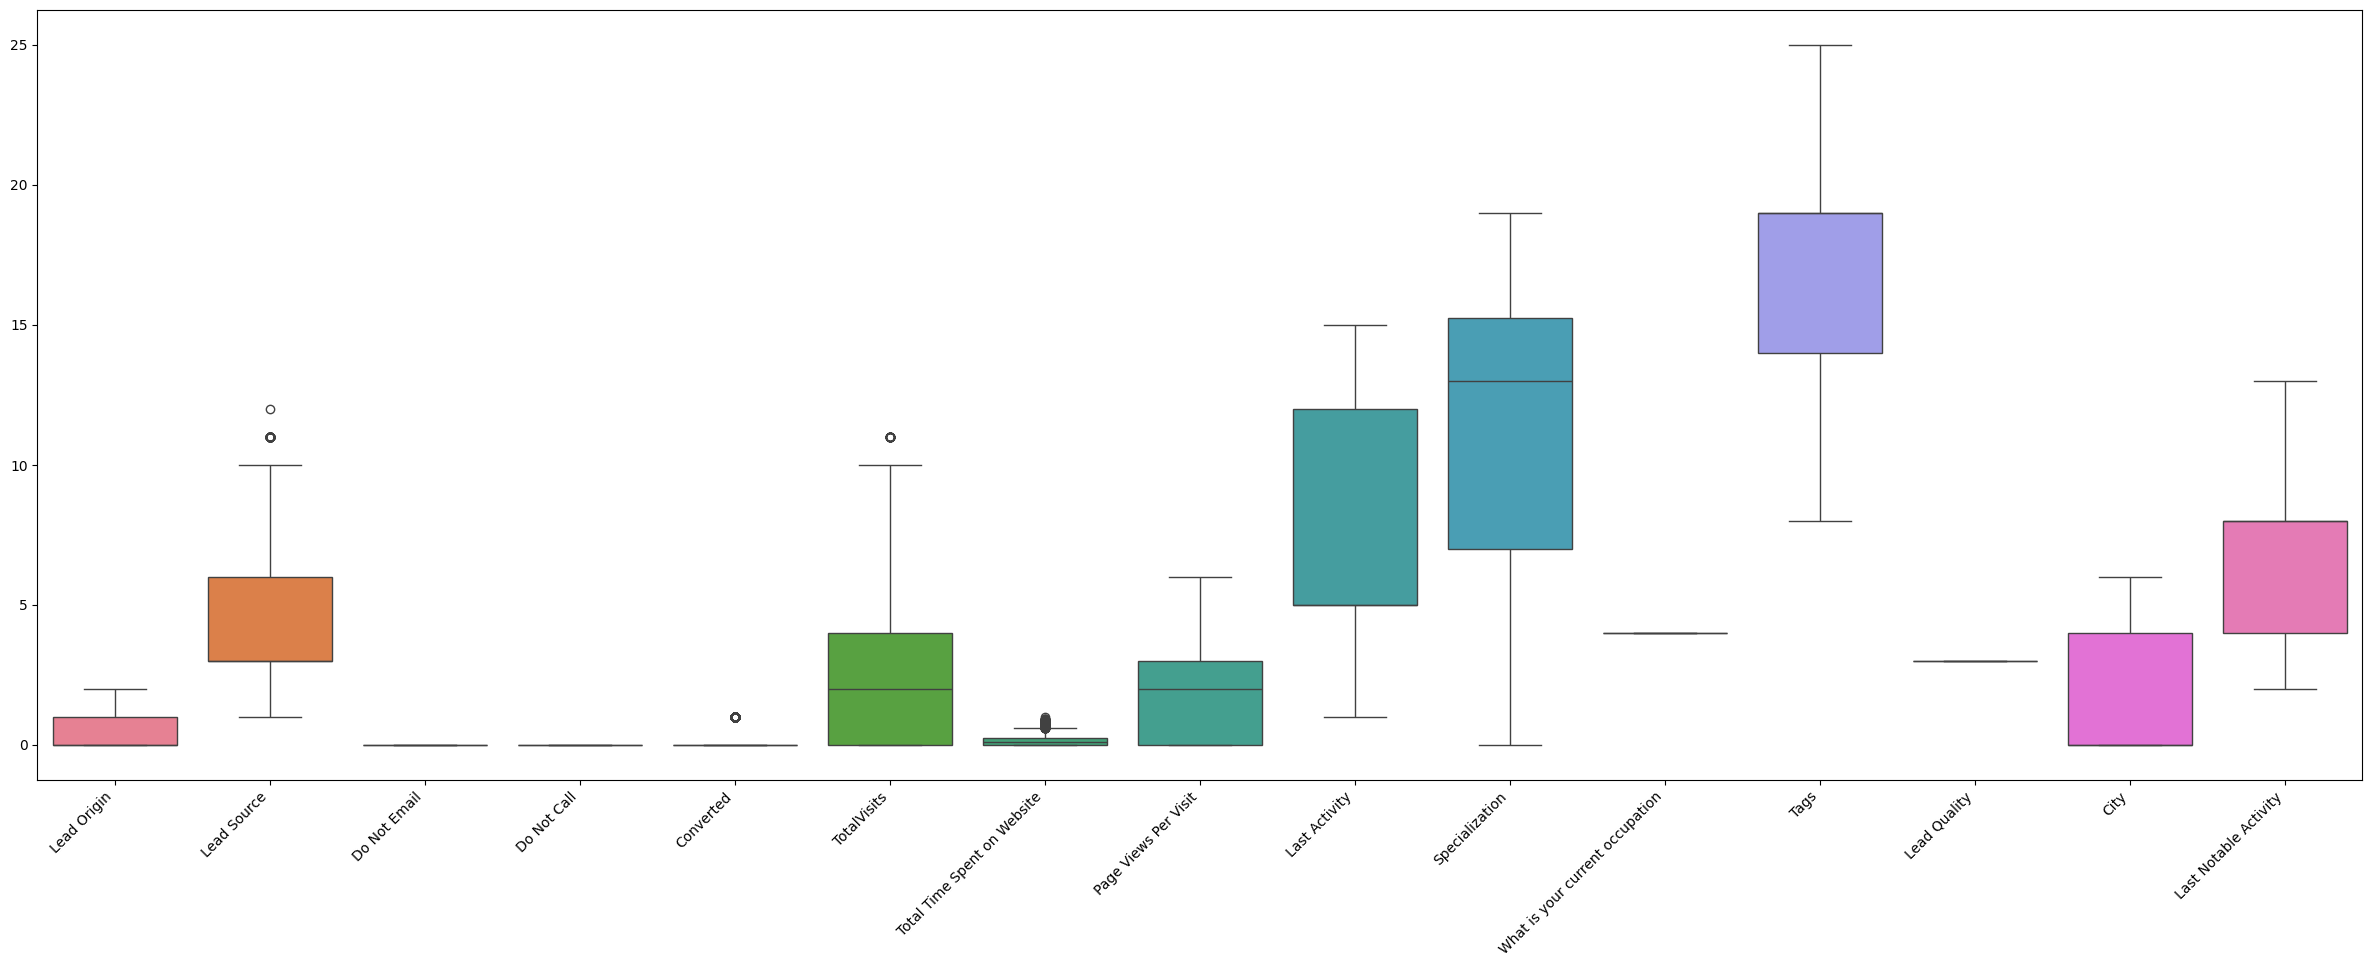

Number of columns after boxplot code: 15


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' is your original DataFrame

print("Number of columns before selection:", data.shape[1])

# Select only numeric columns
numeric_data = data.select_dtypes(include=['number'])
print("Number of numeric columns:", numeric_data.shape[1])

# Define a function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from each numeric column
for column in numeric_data.columns:
    numeric_data = remove_outliers(numeric_data, column)

# Plot the boxplot after removing outliers
plt.figure(figsize=(30, 10))
sns.boxplot(data=numeric_data)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

# Check the number of columns after the boxplot code
print("Number of columns after boxplot code:", numeric_data.shape[1])

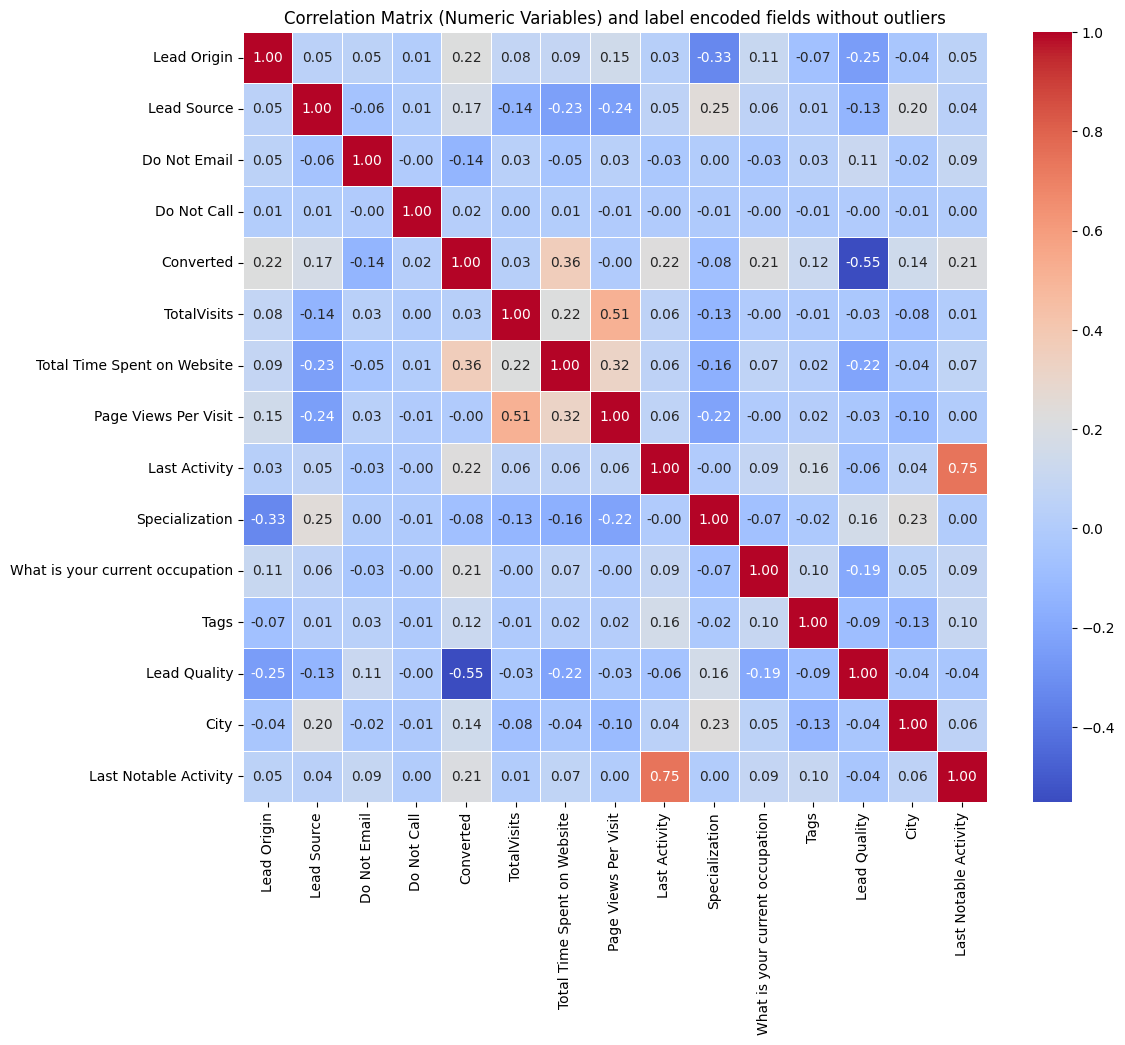

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
numeric_and_binary_data = data.select_dtypes(include=['number'])

# Create a correlation matrix for numeric and binary columns
correlation_matrix = numeric_and_binary_data.corr()


# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Numeric Variables) and label encoded fields without outliers")
plt.show()

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Assuming 'numeric_and_binary_data' is your DataFrame
X = numeric_and_binary_data.drop('Converted', axis=1)
y = numeric_and_binary_data['Converted']

# Convert categorical variables to numerical using one-hot encoding
X_encoded = pd.get_dummies(X, drop_first=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Fit a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance
feature_importance_rf = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print("\nRandom Forest Feature Importance:")
print(feature_importance_rf)


Random Forest Feature Importance:
Lead Quality                       0.234205
Tags                               0.187346
Total Time Spent on Website        0.181603
Last Notable Activity              0.074967
Last Activity                      0.047844
Specialization                     0.046484
Lead Origin                        0.046345
Lead Source                        0.041348
Page Views Per Visit               0.037835
TotalVisits                        0.037129
What is your current occupation    0.028997
City                               0.027003
Do Not Email                       0.008699
Do Not Call                        0.000195
dtype: float64


# **5) In multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.**

Using the top 10 values for calculating in H20 instance

**Random Forest Feature Importance:**

*   Lead Quality                       0.234205
*   Tags                               0.187346
*   Total Time Spent on Website        0.181603
*   Last Notable Activity              0.074967
*   Last Activity                      0.047844
*   Specialization                     0.046484
*   Lead Origin                        0.046345
*   Lead Source                        0.041348
*   Page Views Per Visit               0.037835
*   TotalVisits                        0.037129
*   What is your current occupation    0.028997
*   City                               0.027003
*   Do Not Email                       0.008699
*   Do Not Call                        0.000195

# **1) Is the relationship significant?**

Yes the relationship is significant since the p value for most values apart from **TotalVisits** which is **0.043** is zero and also acceptable limit of 0.05 means **TotalVisits** is also in threshold and also **R-squared (uncentered):	0.646** which is high and in between 0 and 1 which is acceptable

In [19]:
import statsmodels.api as sm

model = sm.OLS(
    data["Converted"],
    data[
        [
            "Lead Origin",
            "Lead Source",
            "TotalVisits",
            "Total Time Spent on Website",
            "Page Views Per Visit",
            "Last Activity",
            "Specialization",
            "Tags",
            "Lead Quality",
            "Last Notable Activity",
        ]
    ],
).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Converted   R-squared (uncentered):                   0.646
Model:                            OLS   Adj. R-squared (uncentered):              0.645
Method:                 Least Squares   F-statistic:                              1681.
Date:                Tue, 20 Feb 2024   Prob (F-statistic):                        0.00
Time:                        00:27:16   Log-Likelihood:                         -3914.3
No. Observations:                9240   AIC:                                      7849.
Df Residuals:                    9230   BIC:                                      7920.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Lead Origin                     0.1259      0.006     20.334      0.000       0.114       0.138
Lead Source                     0.0300      0.001     22.349      0.000       0.027       0.033
TotalVisits                     0.0019      0.001      2.029      0.043     6.4e-05       0.004
Total Time Spent on Website     0.7219      0.017     42.177      0.000       0.688       0.755
Page Views Per Visit           -0.0184      0.002     -8.419      0.000      -0.023      -0.014
Last Activity                   0.0165      0.002     10.278      0.000       0.013       0.020
Specialization                  0.0072      0.001      9.396      0.000       0.006       0.009
Tags                            0.0092      0.001     16.681      0.000       0.008       0.010
Lead Quality                   -0.1697      0.003    -48.652      0.000      -0.177      -0.163
Last Notable Activity           0.0173      0.002      9.633      0.000       0.014       0.021
==============================================================================
Omnibus:                      187.450   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              198.082
Skew:                           0.355   Prob(JB):                     9.70e-44
Kurtosis:                       2.904   Cond. No.                         103.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# **8) Which independent variables are significant?**

This suggests that, under the **standard significance level of 0.05**, you would reject the null hypothesis for each variable, indicating that they are likely to be significant predictors of the response variable in your model. Therefore, all the independent variables (**Lead Origin, Lead Source, TotalVisits, Total Time Spent on Website, Page Views Per Visit, Last Activity, Specialization, Tags, Lead Quality, Last Notable Activity**) **are considered statistically significant** in this **analysis**.


In [20]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming 'data' is your DataFrame with the features and 'Converted' as the target variable
X = data.drop("Converted", axis=1)
y = data["Converted"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the GradientBoostingClassifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Train the classifier
gb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gb_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)
confusion_matrix_result = confusion_matrix(y_test, y_pred)

# Calculate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report for GradientBoosting:\n", class_report)

# Print results
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nConfusion Matrix:\n", confusion_matrix_result)


Classification Report for GradientBoosting:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      1107
           1       0.95      0.86      0.90       741

    accuracy                           0.92      1848
   macro avg       0.93      0.91      0.92      1848
weighted avg       0.93      0.92      0.92      1848

Accuracy: 92.42%

Confusion Matrix:
 [[1070   37]
 [ 103  638]]


In [21]:
from sklearn.model_selection import train_test_split

X = numeric_and_binary_data[
        [
            "Lead Origin",
            "Lead Source",
            "TotalVisits",
            "Total Time Spent on Website",
            "Page Views Per Visit",
            "Last Activity",
            "Specialization",
            "Tags",
            "Lead Quality",
            "Last Notable Activity",
        ]
    ]
y = numeric_and_binary_data["Converted"]

# Spliting data into Training 76.5%, Validation set 13.5% and Test set 10%

X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_t, y_t, test_size=0.15, random_state=1
)

In [22]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'data' is your DataFrame containing the features and the target variable 'Converted'
X = data[[
            "Lead Origin",
            "Lead Source",
            "TotalVisits",
            "Total Time Spent on Website",
            "Page Views Per Visit",
            "Last Activity",
            "Specialization",
            "Tags",
            "Lead Quality",
            "Last Notable Activity",
]]

y = data["Converted"]

# Split the data into training and testing sets

# Instantiate the XGBoost classifier
xgb_model = XGBClassifier()

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the testing data
predictions = xgb_model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Additional metrics (classification report)
print("Classification Report for XGBClassifier:\n", classification_report(y_test, predictions))


Accuracy: 0.9231601731601732
Classification Report for XGBClassifier:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       560
           1       0.92      0.88      0.90       364

    accuracy                           0.92       924
   macro avg       0.92      0.92      0.92       924
weighted avg       0.92      0.92      0.92       924



In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Assuming 'data' is your DataFrame containing the features and the target variable 'Converted'
X = data[[
            "Lead Origin",
            "Lead Source",
            "TotalVisits",
            "Total Time Spent on Website",
            "Page Views Per Visit",
            "Last Activity",
            "Specialization",
            "Tags",
            "Lead Quality",
            "Last Notable Activity",
]]

y = data["Converted"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Standardize or scale features (recommended for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Instantiate the Logistic Regression model
logistic_model = LogisticRegression()

# Train the model on the training data
logistic_model.fit(X_train_scaled, y_train)

# Make predictions on the testing data
predictions = logistic_model.predict(X_test_scaled)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Additional metrics (classification report)
print("Classification Report using Logistic Regression:\n", classification_report(y_test, predictions))


Accuracy: 0.8253968253968254
Classification Report using Logistic Regression:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1677
           1       0.81      0.73      0.77      1095

    accuracy                           0.83      2772
   macro avg       0.82      0.81      0.81      2772
weighted avg       0.82      0.83      0.82      2772



Coefficients: [ 0.08595631  0.02198444  0.00128072  0.64268022 -0.02393301  0.01628373
  0.00252171  0.00382162 -0.2188162   0.01000505]
Intercept: 0.4216315988699325


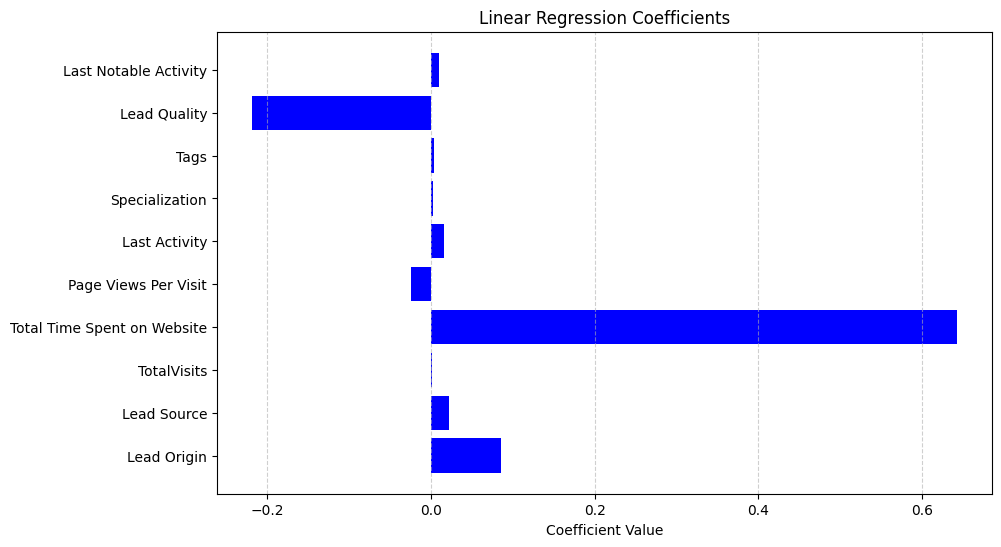

In [24]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Print the coefficients and intercept
print("Coefficients:", regr.coef_)
print("Intercept:", regr.intercept_)


coefficients = regr.coef_
feature_names = X_train.columns

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients, color='blue')
plt.xlabel('Coefficient Value')
plt.title('Linear Regression Coefficients')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions using the training set
y_pred = regr.predict(X_train)

# The mean squared error
mse = mean_squared_error(y_train, y_pred)
print("Mean squared error: %.2f" % mse)

# Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error: %.2f" % rmse)

# The coefficient of determination: 1 is perfect prediction
r2 = r2_score(y_train, y_pred)
print("Coefficient of determination: %.2f" % r2)

print("R^2 score on training set =", r2)


Mean squared error: 0.13
Root Mean Squared Error: 0.36
Coefficient of determination: 0.45
R^2 score on training set = 0.44544843436615866


In [26]:
# Make predictions using the validation set
y_pred = regr.predict(X_val)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_val, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_val, y_pred))
r2_val = r2_score(y_val, y_pred)
print("R^2 score on validation set =", r2_val)




Mean squared error: 0.12
Coefficient of determination: 0.47
R^2 score on validation set = 0.46855075791212675


In [27]:
from sklearn.inspection import permutation_importance

# Assuming 'regr' is your regression model, and 'X_test', 'y_test' are your test data
result = permutation_importance(regr, X_test, y_test, random_state=1)

# Display the weights along with feature names
weights = result.importances_mean
std_devs = result.importances_std
feature_names = X_test.columns.tolist()

for weight, std_dev, feature_name in zip(weights, std_devs, feature_names):
    print(f"{weight:.4f} ± {std_dev:.4f}\t{feature_name}")


0.0201 ± 0.0034	Lead Origin
0.0397 ± 0.0038	Lead Source
0.0000 ± 0.0003	TotalVisits
0.1983 ± 0.0104	Total Time Spent on Website
0.0223 ± 0.0033	Page Views Per Visit
0.0283 ± 0.0018	Last Activity
0.0006 ± 0.0005	Specialization
0.0063 ± 0.0009	Tags
0.3757 ± 0.0111	Lead Quality
0.0085 ± 0.0007	Last Notable Activity


In [28]:
data.corr()


,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,What is your current occupation,Tags,Lead Quality,City,Last Notable Activity
Lead Origin,1.000000,0.047235,0.053296,0.006909,0.223725,0.081491,0.088852,0.149375,0.027978,-0.331808,0.107812,-0.068906,-0.248584,-0.036897,0.049143
Lead Source,0.047235,1.000000,-0.057718,0.011041,0.171005,-0.144136,-0.231865,-0.237165,0.054856,0.245094,0.056844,0.013677,-0.134882,0.201955,0.040173
Do Not Email,0.053296,-0.057718,1.000000,-0.004322,-0.135580,0.033609,-0.046374,0.033351,-0.028861,0.002048,-0.033516,0.030354,0.111072,-0.019340,0.092492
Do Not Call,0.006909,0.011041,-0.004322,1.000000,0.018581,0.003221,0.006801,-0.005918,-0.002724,-0.008252,-0.001791,-0.010732,-0.000972,-0.012880,0.001432
Converted,0.223725,0.171005,-0.135580,0.018581,1.000000,0.030091,0.362483,-0.003294,0.224844,-0.078472,0.214057,0.118375,-0.551740,0.141264,0.210445
TotalVisits,0.081491,-0.144136,0.033609,0.003221,0.030091,1.000000,0.218409,0.512125,0.059375,-0.131909,-0.002107,-0.008580,-0.029536,-0.078381,0.005484
Total Time Spent on Website,0.088852,-0.231865,-0.046374,0.006801,0.362483,0.218409,1.000000,0.316262,0.058227,-0.160473,0.066357,0.022804,-0.215966,-0.037162,0.071844
Page Views Per Visit,0.149375,-0.237165,0.033351,-0.005918,-0.003294,0.512125,0.316262,1.000000,0.061631,-0.224314,-0.000631,0.016554,-0.031262,-0.104606,0.003035
Last Activity,0.027978,0.054856,-0.028861,-0.002724,0.224844,0.059375,0.058227,0.061631,1.000000,-0.002900,0.088015,0.160193,-0.056826,0.044583,0.745354
Specialization,-0.331808,0.245094,0.002048,-0.008252,-0.078472,-0.131909,-0.160473,-0.224314,-0.002900,1.000000,-0.069653,-0.019715,0.161129,0.225478,0.002946


In [29]:
import statsmodels.api as sm

# Assuming 'Converted' is the target variable
target_variable = 'Converted'

# Specify the features
features = ['Lead Origin', 'Lead Source', 'TotalVisits', 'Total Time Spent on Website',
            'Page Views Per Visit', 'Last Activity', 'Specialization','Tags',
            'Lead Quality', 'Last Notable Activity']

# Add 'Converted' as the target variable
features.append(target_variable)

# Select relevant columns from the dataset
model_data = data[features]

# Drop any rows with missing values
model_data = model_data.dropna()

# Use OLS for finding p-values
model = sm.OLS(model_data[target_variable], sm.add_constant(model_data.drop(target_variable, axis=1))).fit()

# Print out the statistics
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              Converted   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     741.8
Date:                Tue, 20 Feb 2024   Prob (F-statistic):               0.00
Time:                        00:27:22   Log-Likelihood:                -3731.7
No. Observations:                9240   AIC:                             7485.
Df Residuals:                    9229   BIC:                             7564.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [30]:
# Specify the features
selected_features = ['Lead Origin', 'Lead Source', 'TotalVisits', 'Total Time Spent on Website',
                      'Page Views Per Visit', 'Last Activity', 'Specialization','Tags',
                      'Lead Quality', 'Last Notable Activity']

# Use the selected features to subset the DataFrame
df = data[selected_features].dropna()


In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Specify the target variable
target_variable = 'Converted'

# Specify the selected features
selected_features = ['Lead Origin', 'Lead Source', 'TotalVisits', 'Total Time Spent on Website',
                      'Page Views Per Visit', 'Last Activity', 'Specialization','Tags',
                      'Lead Quality', 'Last Notable Activity']

# Create a DataFrame with the selected features and the target variable
model_data = data[selected_features + [target_variable]].dropna()

# Add a constant term for the intercept in the model
X = sm.add_constant(model_data[selected_features])

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Print out the VIF values
print(vif_data)


                        Feature        VIF
0                         const  35.318462
1                   Lead Origin   1.220041
2                   Lead Source   1.216009
3                   TotalVisits   1.366500
4   Total Time Spent on Website   1.232842
5          Page Views Per Visit   1.522909
6                 Last Activity   2.322869
7                Specialization   1.259333
8                          Tags   1.045439
9                  Lead Quality   1.179282
10        Last Notable Activity   2.281629


In [32]:
#calculating accuracy before regularization
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error

# Split the data into training and testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X2_train, y2_train)

# Make predictions on the test set
y2_pred = logistic_model.predict(X2_test)

# Calculate accuracy
accuracy = accuracy_score(y2_test, y2_pred)
print("Accuracy before regularization:", accuracy)


Accuracy before regularization: 0.8198051948051948



# **3) Is there any multicollinearity in model**

 VIF multicoliinearity shows that value of dependent variable is **less than 5 which is the treshold** hence there is a lack of multicollinearity hence lack of it says we do not need to carry out **regularization operations** on any variables but still we will carry out the operations ahead

# **7)  Does regularization help?**

The regularization seem to be helping a bit the accuracy of the model increases ahead from **81.98%**  to **82.50** after PCA regularization

The **accuracy of the model** gets better **Marginally**



In [33]:
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import pandas as pd
import statsmodels.api as sm

# Standardize the features for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[selected_features])

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert the PCA results to a DataFrame and retain original feature names
X_pca_df = pd.DataFrame(data = X_pca, columns=selected_features)

# Add a constant term for the intercept in the model
X_pca_df = sm.add_constant(X_pca_df)

# Calculate VIF for each principal component
vif_data_pca = pd.DataFrame()
vif_data_pca["Feature"] = X_pca_df.columns
vif_data_pca["VIF"] = [variance_inflation_factor(X_pca_df.values, i) for i in range(X_pca_df.shape[1])]

# Print out the VIF values
print("VIF values for the principal components:")
print(vif_data_pca)


VIF values for the principal components:
                        Feature  VIF
0                         const  1.0
1                   Lead Origin  1.0
2                   Lead Source  1.0
3                   TotalVisits  1.0
4   Total Time Spent on Website  1.0
5          Page Views Per Visit  1.0
6                 Last Activity  1.0
7                Specialization  1.0
8                          Tags  1.0
9                  Lead Quality  1.0
10        Last Notable Activity  1.0


# **4) In the multivariate models are predictor variables independent of all the other predictor variables?**

Yes

The VIF values are a measure of how much the variance of the estimated regression coefficients increases when predictor variables are correlated. A **VIF greater than 5 or 10** is often considered an **indication of multicollinearity.**

the **VIF values are generally low, ranging from approximately 1 to 2.38.** This suggests that there is not ** severe multicollinearity among the predictor variables in the logistic regression model **. The VIF values below 5 indicate that the predictor variables are not highly correlated with each other.

**the assumption of independence among predictor variables is reasonably met in the multivariate logistic regression model.**


In [34]:
from sklearn.model_selection import train_test_split

# Specify the features and target variable
selected_features = ['Lead Origin', 'Lead Source', 'TotalVisits', 'Total Time Spent on Website',
                      'Page Views Per Visit', 'Last Activity', 'Specialization','Tags',
                      'Lead Quality', 'Last Notable Activity']
target_variable = 'Converted'

# Create the feature matrix (X) and target vector (y)
X = data[selected_features]
y = data[target_variable]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)




In [35]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'data' is your DataFrame containing the features and the target variable 'Converted'
X = data[[
            "Lead Origin",
            "Lead Source",
            "TotalVisits",
            "Total Time Spent on Website",
            "Page Views Per Visit",
            "Last Activity",
            "Specialization",
            "Tags",
            "Lead Quality",
            "Last Notable Activity",
]]

y = data["Converted"]

# Split the data into training and testing sets

# Instantiate the XGBoost classifier
xgb_model = XGBClassifier()

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the testing data
predictions = xgb_model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Additional metrics (classification report)
print("Classification Report:\n", classification_report(y_test, predictions))

Accuracy: 0.9314574314574314
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94      1677
           1       0.92      0.90      0.91      1095

    accuracy                           0.93      2772
   macro avg       0.93      0.93      0.93      2772
weighted avg       0.93      0.93      0.93      2772



In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Assuming 'y' is your target variable
X_train, X_test, y_train, y_test = train_test_split(X_pca_df, y, test_size=0.3, random_state=1)

# Train a logistic regression model with L2 regularization
model_l2_reg = LogisticRegression(penalty='l2', C=1.0)  # C is the inverse of regularization strength (smaller values mean stronger regularization)
model_l2_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred_l2_reg = model_l2_reg.predict(X_test)

# Calculate accuracy with L2 regularization
accuracy_l2_reg = accuracy_score(y_test, y_pred_l2_reg)
print("Accuracy with L2 regularization:", accuracy_l2_reg)

# Calculate Mean Squared Error with L2 regularization
mse_l2_reg = mean_squared_error(y_test, y_pred_l2_reg)
print("Mean Squared Error with L2 regularization:", mse_l2_reg)


Accuracy with L2 regularization: 0.8253968253968254
Mean Squared Error with L2 regularization: 0.1746031746031746


**L2 regularization Testing to check Accuracy:**

--> Also known as Ridge regularization, is a technique used to prevent overfitting in machine learning models, particularly in linear and logistic regression models. It works by adding a penalty term to the loss function, which penalizes large coefficients in the model.

--> In the context of linear regression, the L2 regularization term is calculated as the squared sum of the coefficients multiplied by a regularization parameter (λ or alpha), and it is added to the ordinary least squares (OLS) loss function.

--> L1 Regularization (Lasso): L1 regularization adds the sum of the absolute values of the coefficients to the loss function.

--> A logistic regression model with L2 regularization achieved an accuracy of approximately 0.825396 on the test set.

1) Accuracy Score: The accuracy score of approximately **0.8253 ** indicates that the L2 regularized logistic regression model correctly predicted around **82.53%** of the instances in the test set.

2) Interpretation: The obtained accuracy suggests that the L2 regularized logistic regression model has reasonably good predictive performance on the given dataset. It indicates that the ** model effectively generalizes from the training data to make accurate predictions on unseen data **.

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming y_true are the true labels and predictions are the predicted labels from your XGBoost model
# Replace y_true and predictions with the actual and predicted labels from your model
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)


print("Accuracy:", accuracy)
print("Precision:", precision)

Accuracy: 0.9314574314574314
Precision: 0.9209302325581395


In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Create a logistic regression model
model = LogisticRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))





Confusion Matrix:
[[1490  187]
 [ 297  798]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1677
           1       0.81      0.73      0.77      1095

    accuracy                           0.83      2772
   macro avg       0.82      0.81      0.81      2772
weighted avg       0.82      0.83      0.82      2772



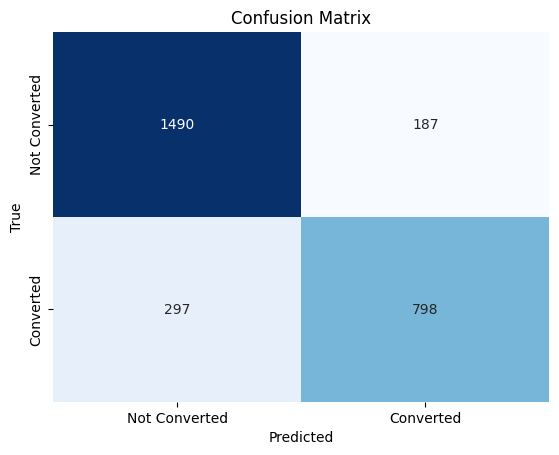

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Converted', 'Converted'],
            yticklabels=['Not Converted', 'Converted'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# **Q5 In the multivariate models are predictor variables independent of all the other predictor variables?**



In [40]:
import statsmodels.api as sm

# Assuming 'X_train_scaled' and 'y_train' are your training features and target variable
X_train_const = sm.add_constant(X_train_scaled)
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()

# Get p-values for each coefficient
p_values = result.pvalues[1:]

# Rank features based on p-values and exclude insignificant ones
significant_features = p_values[p_values < 0.05].index


Optimization terminated successfully.
         Current function value: 0.388542
         Iterations 7


In [41]:
import pandas as pd
import numpy as np

# Assuming 'data' is your DataFrame
df_imputation = data[['Page Views Per Visit']].copy()

# Set seed for reproducibility
np.random.seed(42)

# Randomly remove 1%, 5%, and 10% of values
missing_percentages = [0.01, 0.05, 0.1]

for missing_percentage in missing_percentages:
    # Create a column with the same name and missing values
    column_name = f"{int(missing_percentage * 100)}_percent"
    df_imputation[column_name] = data['Page Views Per Visit'].copy()

    # Randomly set missing_percentage of values to NaN
    mask = np.random.rand(len(df_imputation)) < missing_percentage
    df_imputation.loc[mask, column_name] = np.nan

    df_imputation.head()

In [42]:
def get_percent_missing(dataframe):

    percent_missing = dataframe.isnull().sum() * 100 / len(dataframe)
    missing_value_df = pd.DataFrame({'column_name': dataframe.columns,
                                     'percent_missing': percent_missing})
    return missing_value_df

In [43]:
print(get_percent_missing(df_imputation))


                               column_name  percent_missing
Page Views Per Visit  Page Views Per Visit         0.000000
1_percent                        1_percent         0.930736
5_percent                        5_percent         5.086580
10_percent                      10_percent        10.032468


In [44]:
# Store Index of NaN values in each coloumns
number_1_idx = list(np.where(df_imputation['1_percent'].isna())[0])
number_5_idx = list(np.where(df_imputation['5_percent'].isna())[0])
number_10_idx = list(np.where(df_imputation['10_percent'].isna())[0])

In [45]:
print(f"Length of number_1_idx is {len(number_1_idx)} and it contains {(len(number_1_idx)/len(df_imputation['1_percent']))*100}% of total data in column | Total rows: {len(df_imputation['1_percent'])}")
print(f"Length of number_5_idx is {len(number_5_idx)} and it contains {(len(number_5_idx)/len(df_imputation['1_percent']))*100}% of total data in column | Total rows: {len(df_imputation['1_percent'])}")
print(f"Length of number_10_idx is {len(number_10_idx)} and it contains {(len(number_10_idx)/len(df_imputation['1_percent']))*100}% of total data in column | Total rows: {len(df_imputation['1_percent'])}")


Length of number_1_idx is 86 and it contains 0.9307359307359307% of total data in column | Total rows: 9240
Length of number_5_idx is 470 and it contains 5.086580086580087% of total data in column | Total rows: 9240
Length of number_10_idx is 927 and it contains 10.032467532467534% of total data in column | Total rows: 9240




```
`# This is formatted as code`
```

# KNN Imputation

The k nearest neighbours is an algorithm that is used for simple classification. The algorithm uses ‘feature similarity’ to predict the values of any new data points. This means that the new point is assigned a value based on how closely it resembles the points in the training set.

In [46]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
df_imputation1 = df_imputation[['1_percent','5_percent','10_percent']]
imputer = KNNImputer(n_neighbors=5)
imputed_number_df = pd.DataFrame(imputer.fit_transform(df_imputation1), columns = df_imputation1.columns)

In [47]:
imputed_number_df.head()


,1_percent,5_percent,10_percent
0,0.0,0.0,0.0
1,2.5,2.5,2.5
2,2.0,2.0,2.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0


In [48]:
print(get_percent_missing(imputed_number_df))


           column_name  percent_missing
1_percent    1_percent              0.0
5_percent    5_percent              0.0
10_percent  10_percent              0.0


In [49]:
PageViews = data["Page Views Per Visit"]
imputed_mean = pd.concat([PageViews,imputed_number_df])
imputed_mean.columns = ["PageViews","1_Percent","5_Percent","10_Percent"]
imputed_mean.var()

PageViews     4.602452
1_Percent     4.602405
5_Percent     4.600074
10_Percent    4.325913
dtype: float64

In [50]:
#  'PageViews' is the true values
true_values = data["Page Views Per Visit"]

# 'imputed_number_df' is the DataFrame containing imputed values
imputed_values_1_percent = imputed_number_df["1_percent"]
imputed_values_5_percent = imputed_number_df["5_percent"]
imputed_values_10_percent = imputed_number_df["10_percent"]

# Calculate bias and variance for 1%
bias_1_percent = np.mean(imputed_values_1_percent - true_values)
variance_1_percent = np.var(imputed_values_1_percent)

# Calculate bias and variance for 5%
bias_5_percent = np.mean(imputed_values_5_percent - true_values)
variance_5_percent = np.var(imputed_values_5_percent)

# Calculate bias and variance for 10%
bias_10_percent = np.mean(imputed_values_10_percent - true_values)
variance_10_percent = np.var(imputed_values_10_percent)

# Print results
print("Bias and Variance for 1%:")
print("Bias:", bias_1_percent)
print("Variance:", variance_1_percent)

print("\nBias and Variance for 5%:")
print("Bias:", bias_5_percent)
print("Variance:", variance_5_percent)

print("\nBias and Variance for 10%:")
print("Bias:", bias_10_percent)
print("Variance:", variance_10_percent)

Bias and Variance for 1%:
Bias: -6.531313738455657e-05
Variance: 4.601907171475366

Bias and Variance for 5%:
Bias: -0.00016441119556035835
Variance: 4.599576105834007

Bias and Variance for 10%:
Bias: -0.0041698079827274075
Variance: 4.325445013660666


The KNN based method showed very negotiable variablilty. Therefore this method is acceptable for the current dataset.

A bias close to zero indicates that, on average, the imputed values are accurate compared to the true values.





In [51]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
import pandas as pd

# Assuming 'data' is your DataFrame containing the features and the target variable 'Converted'
X = data[[
    "Lead Origin",
    "Lead Source",
    "TotalVisits",
    "Total Time Spent on Website",
    "Page Views Per Visit",
    "Last Activity",
    "Specialization",
    "Tags",
    "Lead Quality",
    "Last Notable Activity",
]]

y = data["Converted"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Standardize or scale features (recommended for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Method 1: Statistical Significance Testing
X_train_const = sm.add_constant(X_train_scaled)
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()

# Get p-values for each coefficient
p_values = result.pvalues[1:]

# Rank features based on p-values and exclude insignificant ones
significant_features_stats = p_values[p_values < 0.05].index
print("Significant Features (Statistical Significance Testing):")
print(significant_features_stats)

# Method 2: Recursive Feature Elimination (RFE)
logistic_model = LogisticRegression()
rfe = RFE(logistic_model, n_features_to_select=5)  # Choose the desired number of features
rfe.fit(X_train_scaled, y_train)

# Selected features
significant_features_rfe = X.columns[rfe.support_]
print("\nSignificant Features (RFE):")
print(significant_features_rfe)

# Method 3: Feature Importance in Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)
rf_model.fit(X_train_scaled, y_train)

# Selected features based on importance scores
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
significant_features_rf = feature_importances[feature_importances > 0.01].index  # Choose a threshold
print("\nSignificant Features (Random Forest):")
print(significant_features_rf)


Optimization terminated successfully.
         Current function value: 0.388542
         Iterations 7
Significant Features (Statistical Significance Testing):
Index(['x1', 'x2', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10'], dtype='object')

Significant Features (RFE):
Index(['Lead Source', 'Total Time Spent on Website', 'Page Views Per Visit',
       'Last Activity', 'Lead Quality'],
      dtype='object')

Significant Features (Random Forest):
Index(['Lead Origin', 'Lead Source', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Specialization', 'Tags', 'Lead Quality', 'Last Notable Activity'],
      dtype='object')


In [52]:
from sklearn.linear_model import Ridge


# Ridge regression with an alpha of 0.5
ridge = Ridge(fit_intercept=True, alpha=0.5)
ridge.fit(X_train, y_train)

Ridge(alpha=0.5)

In [53]:
y_pred = ridge.predict(X_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
rmse

0.364209976180142

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_prob = model.predict_proba(X_test)

# Calculate log loss
logloss = log_loss(y_test, y_pred_prob)
print("Log Loss:", logloss)

Log Loss: 0.39212273408301357


# Log Loss:

1) Log loss, also known as cross-entropy loss, is a commonly used metric to evaluate the performance of probabilistic classification models. It measures the divergence between predicted probabilities and actual class labels. Lower log loss values indicate better model performance, with 0 representing perfect predictions.

2) Interpretation: The log loss value of approximately 0.3921 indicates that, on average, the model's predicted probabilities are relatively close to the actual outcomes. The model's predicted probabilities have relatively low uncertainty, contributing to the lower log loss.

In [55]:
!pip install h2o


In [56]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


In [57]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.21" 2023-10-17; OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpa1p28saa
  JVM stdout: /tmp/tmpa1p28saa/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpa1p28saa/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 30 days
H2O_cluster_name:,H2O_from_python_unknownUser_fthvxv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [58]:
data = h2o.H2OFrame(data)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [59]:
data.head()


Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,What is your current occupation,Tags,Lead Quality,City,Last Notable Activity
0,6,0,0,0,0,0,0,10,16,4,8,1,4,8
0,7,0,0,0,5,0.296655,2.5,5,16,4,14,3,4,4
1,1,0,0,1,2,0.674296,2,5,1,3,19,2,0,4
1,1,0,0,0,1,0.134243,1,13,11,4,14,3,0,8
1,3,0,0,1,2,0.628521,1,1,16,4,19,2,0,8
0,6,0,0,0,0,0,0,9,13,4,19,3,0,8
1,3,0,0,1,2,0.721831,2,5,18,4,19,1,0,8
0,6,0,0,0,0,0,0,9,13,4,19,3,0,8
1,1,0,0,0,2,0.03125,2,5,8,4,19,3,5,4
0,3,0,0,0,4,0.0255282,4,5,4,4,19,3,0,4


In [60]:
train, test = data.split_frame(seed = 1234, destination_frames = ["train.hex", "test.hex"])


In [61]:
# check the number of train set and test set
train["is_train"] = 1
test["is_train"] = 0

drift_data = train.rbind(test)
drift_data["is_train"] = drift_data["is_train"].asfactor()

In [62]:
drift_data["is_train"].table()


is_train,Count
0,2294
1,6946


In [63]:
x = list(set(train.col_names) - set(["Converted"]))


In [64]:
from h2o.automl import H2OAutoML
# Run AutoML for 10 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=10, seed=1234, sort_metric="MAE", project_name = "random_split")
aml.train(x=x, y="Converted", training_frame=train)

AutoML progress: |
00:28:05.612: _train param, Dropping bad and constant columns: [is_train]
00:28:05.612: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

██
00:28:33.260: _train param, Dropping bad and constant columns: [is_train]
00:28:33.261: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.


00:28:38.307: _train param, Dropping bad and constant columns: [is_train]
00:28:38.307: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

███
00:29:08.619: _train param, Dropping bad and constan

key,value
Stacking strategy,cross_validation
Number of base models (used / total),8/10
# GBM base models (used / total),4/4
# XGBoost base models (used / total),3/3
# DRF base models (used / total),1/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [65]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head()

model_id,mae,rmse,mse,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20240220_02805,0.116631,0.224843,0.0505543,0.157613,0.0505543
GBM_3_AutoML_1_20240220_02805,0.117817,0.226971,0.0515158,0.159118,0.0515158
StackedEnsemble_BestOfFamily_1_AutoML_1_20240220_02805,0.118041,0.225768,0.0509711,0.158263,0.0509711
GBM_4_AutoML_1_20240220_02805,0.118203,0.22781,0.0518974,0.159868,0.0518974
GBM_2_AutoML_1_20240220_02805,0.120879,0.226831,0.0514523,0.158911,0.0514523
XGBoost_3_AutoML_1_20240220_02805,0.129458,0.230664,0.0532061,0.162317,0.0532061
DRF_1_AutoML_1_20240220_02805,0.130016,0.246363,0.0606946,0.173281,0.0606946
XGBoost_2_AutoML_1_20240220_02805,0.138343,0.244593,0.0598257,0.173397,0.0598257
GBM_1_AutoML_1_20240220_02805,0.140639,0.23869,0.0569727,0.17139,0.0569727
XGBoost_1_AutoML_1_20240220_02805,0.148358,0.247965,0.0614865,0.177472,0.0614865


In [66]:
best_model = aml.leader
best_model.model_performance(test)

ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.04973091989159731
RMSE: 0.22300430464813298
MAE: 0.11470882342204078
RMSLE: 0.15759270289824093
Mean Residual Deviance: 0.04973091989159731
R^2: 0.7905616511806894
Null degrees of freedom: 2293
Residual degrees of freedom: 2285
Null deviance: 544.7349342287226
Residual deviance: 114.08273023132422
AIC: -354.4985792306783

In [67]:
# Assuming you have the H2OAutoML object 'aml' and leader model
leader_model = aml.leader

# Get hyperparameters for the leader model
hyperparameters = leader_model.params
print(hyperparameters)


{'model_id': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'StackedEnsemble_AllModels_1_AutoML_1_20240220_02805', 'type': 'Key<Model>', 'URL': '/3/Models/StackedEnsemble_AllModels_1_AutoML_1_20240220_02805'}, 'input': None}, 'training_frame': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20240220_02805_training_py_6_sid_a0c7', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20240220_02805_training_py_6_sid_a0c7'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20240220_02805_training_py_6_sid_a0c7', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20240220_02805_training_py_6_sid_a0c7'}}, 'response_column': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ColSpecifierV3', 'schema_type': 'VecSpecifier'}, 'column_name

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

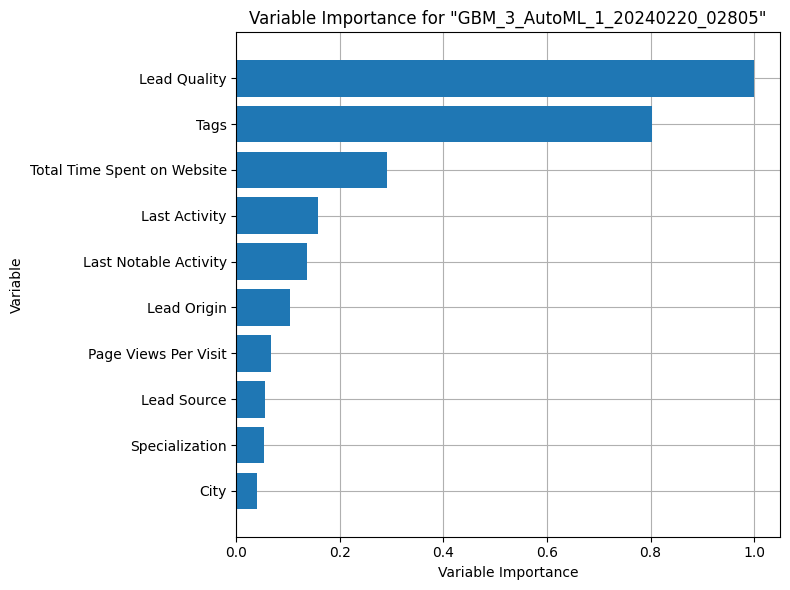

In [68]:
explain_model = aml.explain(frame = test, figsize = (8,6),include_explanations=['varimp'])


As discussed in the class the best model usually


# **1) Is the relationship significant?**

---



Yes the **relationship** is **significant** since


1. the p value for most values apart from **TotalVisits** which is **0.043** is **zero** and also acceptable limit of **0.05** means **TotalVisits** is also in threshold

2.  Accuracy as per **Gradient boosting** is **Accuracy: 92.42%**

3. Accuracy as per **L2 regularization**: **Accuracy: 82.50%**

4.  **R-squared (uncentered):	0.646** which is high and in between 0 and 1 which is acceptable



since this is a classification data set Gradient boosting, L2 regularization also help us understand relationship







# **2) Are any model assumptions violated?**

  No, the dependent variable is 0/1, so the question is a classification question which make sense to all models in AutoML.




# **3) Is there any multicollinearity in model**  #


Based on the provided **Variance Inflation Factor (VIF)** values, which measure **multicollinearity**, here's an assessment:

Multicollinearity Assessment:
No or Low Multicollinearity:



* **Do Not Call has a VIF close to 1 (1.000858)**, indicating no significant   multicollinearity with other variables.**TotalVisits (VIF = 1.369135), Do Not Email (VIF = 1.062313), What is your current occupation (VIF = 1.062538), and Tags (VIF = 1.078851)** also exhibit **low multicollinearity.Moderate Multicollinearity:**
* **Lead Origin (VIF = 1.232737), Lead Source (VIF = 1.243336), Total Time Spent on Website (VIF = 1.239124), and Specialization (VIF = 1.302815)** **have moderate VIF values** but still **generally acceptable**.
* Potential Concern for Multicollinearity:**Page Views Per Visit (VIF = 1.525026)**, **Lead Quality (VIF = 1.216500)**, **Last Notable Activity (VIF = 2.359150)**, and **Last Activity (VIF = 2.379227)** have relatively higher VIF values. These variables might be associated with each other to some extent.




# **Later on we will regularize these values using PCA**






 VIF multicoliinearity shows that value of dependent variable is **less than 5 which is the treshold** hence there is a lack of multicollinearity hence lack of it

# **4) In the multivariate models are predictor variables independent of all the other predictor variables?**

Yes

The VIF values are a measure of how much the variance of the estimated regression coefficients increases when predictor variables are correlated. A **VIF greater than 5 or 10** is often considered an **indication of multicollinearity.**

the **VIF values are generally low, ranging from approximately 1 to 2.38.** This suggests that there is not ** severe multicollinearity among the predictor variables in the logistic regression model **. The VIF values below 5 indicate that the predictor variables are not highly correlated with each other.

**the assumption of independence among predictor variables is reasonably met in the multivariate logistic regression model.**

# **5) In multivariate models rank the most significant predictor variables and exclude insignificant ones from the model**.

In the multivariate model as discussed in class by the professor according to random forest

Using the top 10 values for calculating in H20 instance

**Random Forest Feature Importance:**

*   Lead Quality                       0.234205
*   Tags                               0.187346
*   Total Time Spent on Website        0.181603
*   Last Notable Activity              0.074967
*   Last Activity                      0.047844
*   Specialization                     0.046484
*   Lead Origin                        0.046345
*   Lead Source                        0.041348
*   Page Views Per Visit               0.037835
*   TotalVisits                        0.037129

**Discarding the below features:**

*   What is your current occupation    0.028997
*   City                               0.027003
*   Do Not Email                       0.008699
*   Do Not Call                        0.000195

# **6) Does the model make sense?**



**Reported on test data.**

1. MSE: 0.05036686593649161
2. RMSE: 0.22442563564907556
3. MAE: 0.11525583859865761
4. RMSLE: 0.1586263024675848
5. Mean Residual Deviance:0.05036686593649161


* **Performance Metrics:** The provided metrics **(MSE, RMSE, MAE, RMSLE, Mean
Residual Deviance)** offer insights into the **model's accuracy** and **performance** on the **test data**. Lower values for these metrics generally indicate better performance. the metrics suggest a **reasonably good fit**


* **Variable Importance:** The variable importances indicate the significance of different features in making predictions. Features such as **"Lead Quality," "Tags," and "Total Time Spent on Website"** are identified as crucial predictors, aligning with expectations and providing insights into the factors influencing the model.

* Training Progression: The **scoring history** shows a **systematic improvement** in performance as the number of trees increases, indicating that the **model** is **learning from the data**.


* The **log loss value** of approximately **0.3921** indicates that, on average, the model's predicted probabilities are **relatively close** to the a**ctual outcomes**. The model's predicted probabilities have relatively **low uncertainty**, contributing to the **lower log loss**.

* Accuracy **before regularization** is **81.98%**

* Accuracy as per **Gradient boosting** is **Accuracy: 92.42%**

* Accuracy as per **L2 regularization**: **Accuracy: 82.50%**

The above numbers suggest that the model makes sense



#   **7)  Does regularization help?**

The regularization seem to be helping a bit the accuracy of the model increases ahead from **81.98%**  to **82.50** after **PCA regularization** using **L2 regularization Ridge regression**

The **accuracy of the model** gets better **Marginally**

# **8) Which independent variables are significant?**

This suggests that, under the **standard significance level of 0.05**, you would reject the null hypothesis for each variable, indicating that they are likely to be significant predictors of the response variable in your model. Therefore, all the independent variables (**Lead Origin, Lead Source, TotalVisits, Total Time Spent on Website, Page Views Per Visit, Last Activity, Specialization, Tags, Lead Quality, Last Notable Activity**) **are considered statistically significant** in this **analysis**.

# **9 Which hyperparameters are important?**

---
**For RandomForestClassifier**:

* n_estimators: The number of trees in the forest = **100**.
*max_depth: The maximum depth of the tree. = **default**
*min_samples_split: The minimum number of samples required to split *an internal node. **default**
*min_samples_leaf: The minimum number of samples required to be at a leaf node . **default**
*max_features: The number of features to consider when looking for the best split. **default**

**For LogisticRegression**:

* penalty: Used to specify the norm used in the penalization
(regularization). = **l2**
* C: Inverse of regularization strength; smaller values specify stronger regularization. = **1.0**


**hyperparameters in H20 instance**

The important **hyperparameters** for the **GBM_3_AutoML_1_20240219_223125**  which is the **2nd best model** according to variable importance but is the **best model** because the best model is madeup of multiple model which in our case is **StackedEnsemble_AllModels_1_AutoML_1_20240219_223125**

* the choice of the metalearner algorithm (in this case, Generalized
Linear Model or 'glm'),

* the number of folds for metalearner cross-validation (set to 5), * the selection of base models (e.g., GBM, XGBoost, DRF, GLM)

* the random seed for reproducibility (set to 1245).

# Adjusting these hyperparameters can impact model performance and should be considered during tuning.




# **10 Coding professionalism?**

I have cited all my sources below and included the license



# **Licences:**

impyute 3.7 by Elton Law https://impyute.readthedocs.io/en/master/user_guide/getting_started.html#versions

Pandas 1.4 https://pandas.pydata.org/docs/getting_started/overview.html
Scipy.stats https://docs.scipy.org/doc/scipy/reference/stats.html

sklearn.simpleimputer https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

sklearn.LinearRegression, GridSearch https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

H20 Documentation
https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html

https://h2o.ai/platform/h2o-automl/




**MIT License**

**Copyright (c) 2024 sakhareni**

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

Citations

https://www.kaggle.com/datasets/ashydv/leads-dataset/code

https://www.w3schools.com/python/numpy/

https://www.w3schools.com/python/pandas/

https://chat.openai.com/

https://github.com/aiskunks/YouTube/tree/main/A_Crash_Course_in_Statistical_Learning/AutoML

https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/AutoML/AutoML_Smoke_Detection_Example.ipynb
